## Lung Cancer Classification

In [15]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix


import cv2
import os
import gc

In [3]:
path = "lung_colon_image_set/lung_image_sets"
classes = os.listdir(path)
print(classes)

['lung_aca', 'lung_n', 'lung_scc']


Explore the images for each class

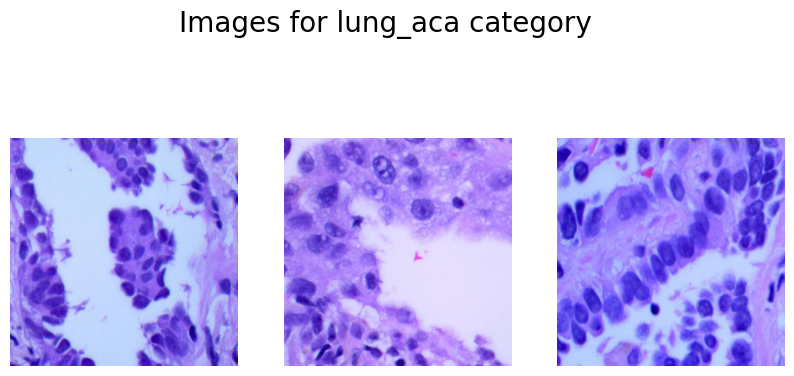

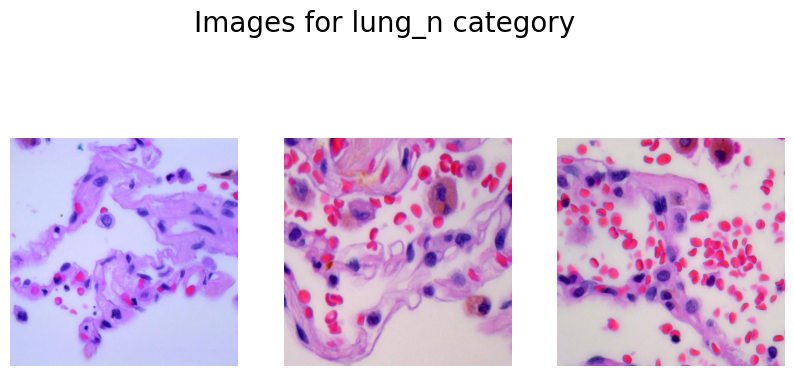

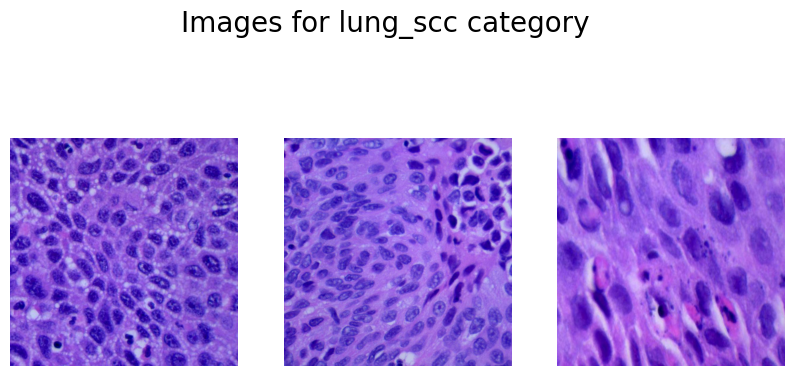

In [4]:
for c in classes:
    image_dir = f"{path}/{c}"
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(10,5))
    fig.suptitle(f"Images for {c} category", fontsize=20)

    # Display 3 random images from each class
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{c}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

Prepare the data for training

In [5]:
# Hyperparamters
IMG_SIZE = 256
BATCH_SIZE = 64
SPLIT = 0.3

In [6]:
X = []
Y = []

for i, cat in enumerate(classes):
    print(i, cat)
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images[:750]:
        img = cv2.imread(image)

        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

0 lung_aca
1 lung_n
2 lung_scc


In [7]:
print('Shape of training data: ', X.shape)
print('Shape of test data: ', one_hot_encoded_Y.shape)

Shape of training data:  (2250, 256, 256, 3)
Shape of test data:  (2250, 3)


In [8]:
# Split the datasets into train and test sets
train_X, test_X, train_Y, test_Y = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=42)

print("X Training set: ", train_X.shape)
print("X Test set: ", test_X.shape)
print("Y Training set: ", train_Y.shape)
print("Y Test set: ", test_Y.shape)

X Training set:  (1575, 256, 256, 3)
X Test set:  (675, 256, 256, 3)
Y Training set:  (1575, 3)
Y Test set:  (675, 3)


Build the CNN model

CNN Model Architecure

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def build_model(lr):
    # Input layer
    input_layer = Input(shape=train_X.shape[1:])

    # Hidden Layers
    x = Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same")(input_layer)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    # Output Layer
    output_layer = Dense(3, activation="softmax")(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(0.01)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,682,755 (128.49 MB)

 Trainable params: 33,681,987 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

In [10]:
def train_model(epochs=50, batch_size=32):
    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

    history = model.fit(
        train_X, 
        train_Y, 
        epochs=epochs,
        batch_size=batch_size, 
        validation_data=(test_X, test_Y),
        callbacks=[early_stop, reduce_lr]
    )
    return history

In [11]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
learning_rates = [0.01, 0.001, 0.0001]
pred_values = []
for lr in learning_rates:
    model = build_model(lr)
    history = train_model()
    
    pred = model.predict(test_X)
    pred_values.append([pred, lr]) 

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 797ms/step - accuracy: 0.6338 - loss: 0.8192 - val_accuracy: 0.3422 - val_loss: 5.7766 - learning_rate: 0.0100
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 833ms/step - accuracy: 0.7656 - loss: 0.4835 - val_accuracy: 0.3022 - val_loss: 6.5541 - learning_rate: 0.0100
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 805ms/step - accuracy: 0.7860 - loss: 0.4591 - val_accuracy: 0.6326 - val_loss: 1.2551 - learning_rate: 0.0100
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 772ms/step - accuracy: 0.8500 - loss: 0.3487 - val_accuracy: 0.3452 - val_loss: 12.3458 - learning_rate: 0.0100
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 729ms/step - accuracy: 0.8494 - loss: 0.3684 - val_accuracy: 0.3452 - val_loss: 15.3975 - learning_rate: 0.0100
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.8625 - loss: 0.3526
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 703ms/step - accuracy: 0.8624 - loss: 0.

Confusion Matrix for 0.01: [[  0  26 217]
 [  0 195   4]
 [  0   1 232]]


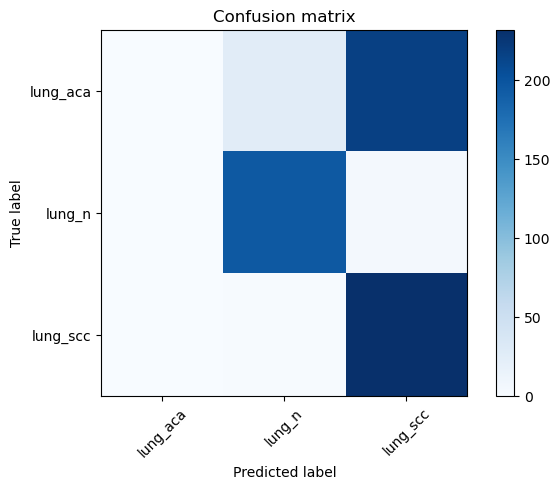

Confusion Matrix for 0.001: [[208   0  35]
 [ 95 100   4]
 [ 51   0 182]]


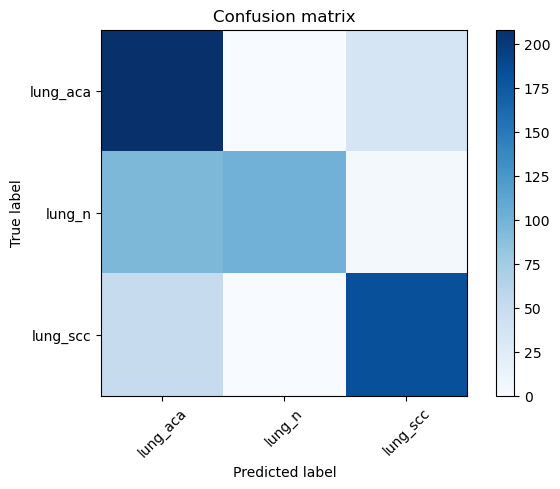

Confusion Matrix for 0.0001: [[ 50   0 193]
 [ 30  18 151]
 [  1   0 232]]


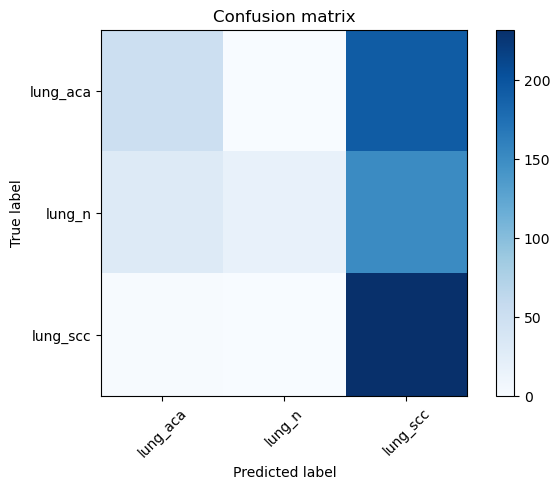

In [21]:
for x in pred_values:
    pred, lr = x[0], x[1]
    
    pred_classes = np.argmax(pred, axis=1)
    true_classes = np.argmax(test_Y, axis=1)

    cm = confusion_matrix(true_classes, pred_classes)

    print(f'Confusion Matrix for {lr}: {cm}')
    plt.figure()
    plot_confusion_matrix(cm, classes)
    plt.show()